# Instalar e carregar pacotes necessários

In [237]:
!pip freeze > requirements.txt

In [238]:
!pip install prince

In [239]:
!pip install statstests

In [240]:
!pip install factor_analyzer

In [241]:
!pip install pingouin

In [242]:
!pip install xgboost


In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.cluster import KMeans
import prince
import numpy as np
import plotly.express as px
from statstests.process import stepwise
from statstests.tests import shapiro_francia
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
import pingouin as pg
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')
from wordcloud import WordCloud
from collections import Counter
warnings.filterwarnings("ignore")
import pickle

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Análise exploratória dos dados

In [244]:
df = pd.read_csv('/content/teste_indicium_precificacao.csv')
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [246]:
df.isna().sum()

,0
id,0
nome,16
host_id,0
host_name,21
bairro_group,0
bairro,0
latitude,0
longitude,0
room_type,0
price,0


Como há abundância de dados, optei por as linhas que possuem dados ausentes.

In [247]:
df = df.dropna()

In [248]:
df.duplicated().sum()

0

In [249]:
df['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce')

print(df['ultima_review'].min())
print(df['ultima_review'].max())

2011-03-28 00:00:00
2019-07-08 00:00:00


Como a variável resposta "price" é dada em dólar, que está sujeito a variações causadas por fatores econômicos, políticos e sociais, optei por utilizar apenas os dados dos últimos 2 anos.

In [250]:
data_final = df['ultima_review'].max()
data_inicial = data_final - pd.DateOffset(years=2)
df = df.loc[(df['ultima_review'] >= data_inicial) & (df['ultima_review'] <= data_final)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33178 entries, 0 to 48851
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             33178 non-null  int64         
 1   nome                           33178 non-null  object        
 2   host_id                        33178 non-null  int64         
 3   host_name                      33178 non-null  object        
 4   bairro_group                   33178 non-null  object        
 5   bairro                         33178 non-null  object        
 6   latitude                       33178 non-null  float64       
 7   longitude                      33178 non-null  float64       
 8   room_type                      33178 non-null  object        
 9   price                          33178 non-null  int64         
 10  minimo_noites                  33178 non-null  int64         
 11  numero_de_reviews   

In [251]:
"""Selecionar apenas variáveis numéricas para avaliar a correlação"""

df_num = df.drop(columns = ['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro', 'room_type'])

<Figure size 2000x1000 with 0 Axes>

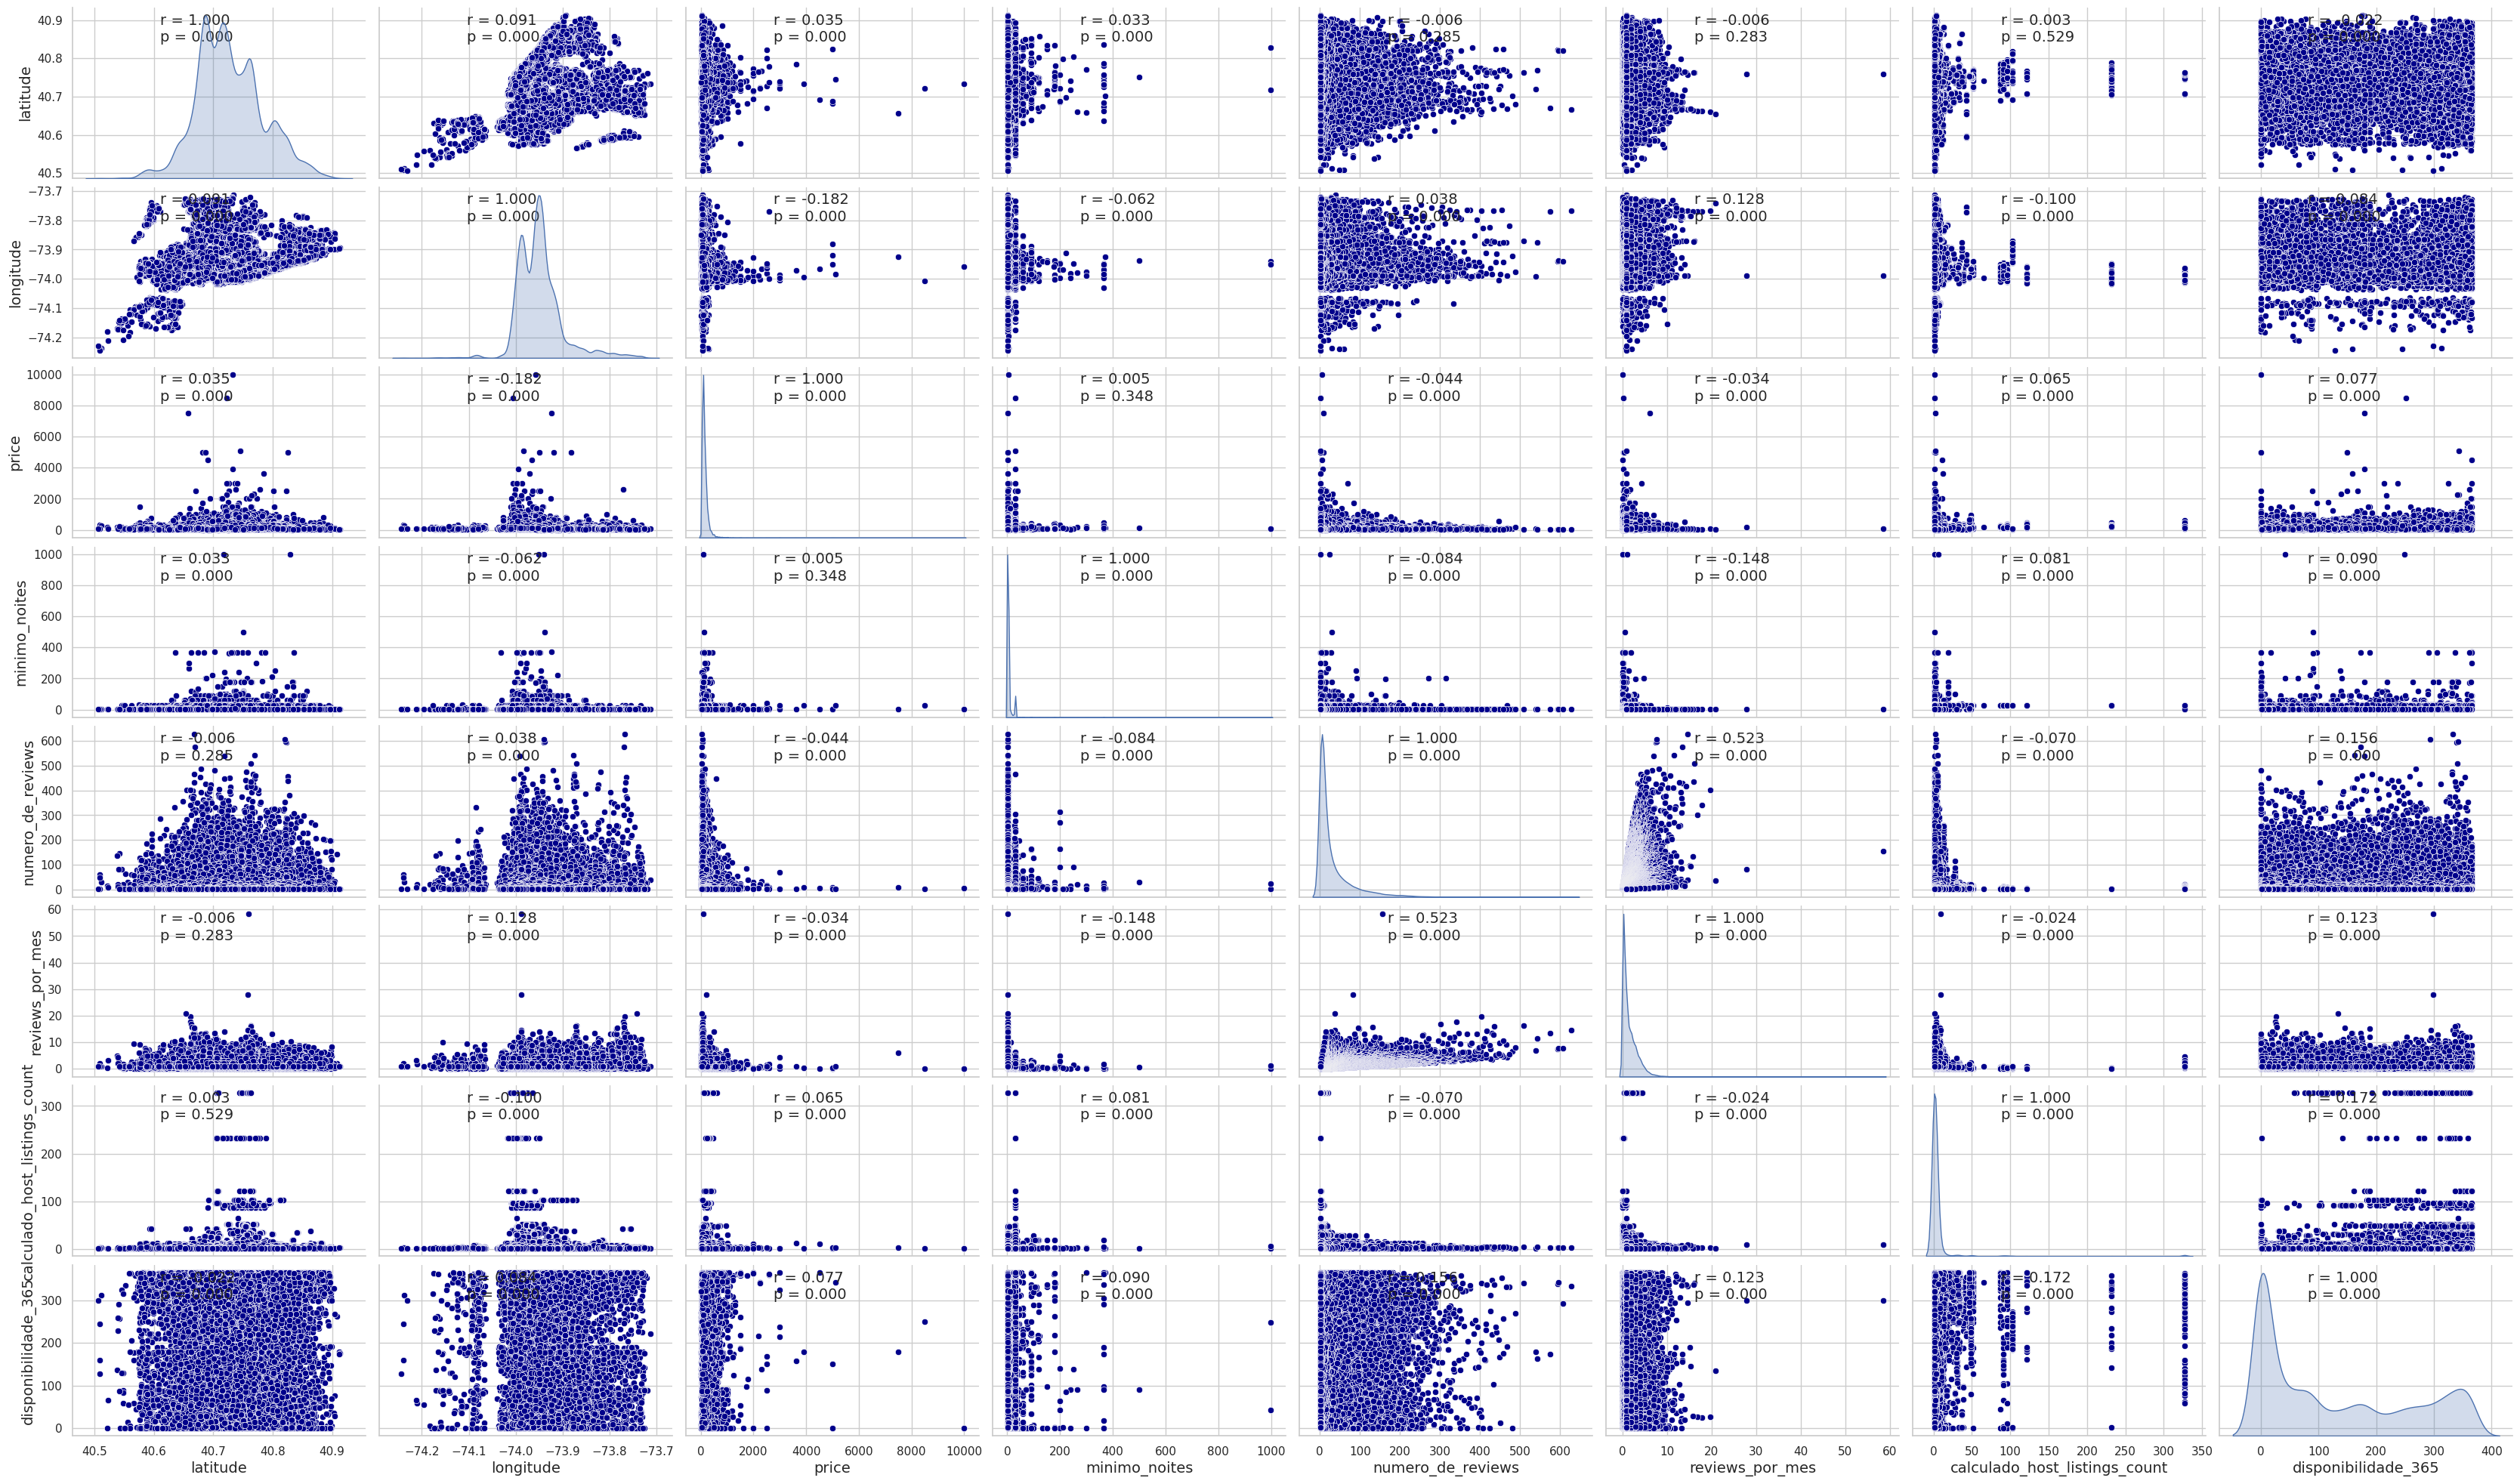

In [252]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.30, .9), xycoords=ax.transAxes, fontsize=14)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.30, .8), xycoords=ax.transAxes, fontsize=14)

"""Configuração do gráfico"""
sns.set(style="whitegrid")

plt.figure(figsize=(20,10))
graph = sns.pairplot(df_num, diag_kind="kde", plot_kws={"color": "darkblue"},
                     height=2.5, aspect=1.7)
graph.map(corrfunc)
for ax in graph.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.show()

Após análise visual, optei por retirar outliers apenas de `price`, `minimo_noites` e `reviews_por_mes`, que apresentaram poucos valores discrepantes.

As outras variáveis também apresentaram alguns valores muito maiores que a grande maioria. No entanto, como existe uma quantidade maior destas observações, suponho que seja algo natural e, portanto, decidi mantê-las.

In [253]:
def remover_outliers(df, columns):
  df_clean = df.copy()
  for column in columns:
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
  return df_clean

df_clean = remover_outliers(df, ['price', 'minimo_noites', 'reviews_por_mes'])

df = df_clean

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26860 entries, 0 to 48851
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             26860 non-null  int64         
 1   nome                           26860 non-null  object        
 2   host_id                        26860 non-null  int64         
 3   host_name                      26860 non-null  object        
 4   bairro_group                   26860 non-null  object        
 5   bairro                         26860 non-null  object        
 6   latitude                       26860 non-null  float64       
 7   longitude                      26860 non-null  float64       
 8   room_type                      26860 non-null  object        
 9   price                          26860 non-null  int64         
 10  minimo_noites                  26860 non-null  int64         
 11  numero_de_reviews   

Após a remoção dos outliers, observa-se abaixo que **o número mínimo de noites e a disponibilidade ao longo do ano não têm interferem no preço**, tendo em vista que não há correlação entre estas variáveis (correlação igual a zero).


In [254]:
matriz_corr = pg.rcorr(df_num, method = 'pearson', upper = 'pval',
                       decimals = 4,
                       pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

print(matriz_corr)

                              latitude longitude    price minimo_noites  \
latitude                             -       ***      ***           ***   
longitude                       0.0909         -      ***           ***   
price                           0.0347   -0.1823        -                 
minimo_noites                   0.0329   -0.0617   0.0052             -   
numero_de_reviews              -0.0059    0.0382  -0.0438       -0.0835   
reviews_por_mes                -0.0059    0.1282  -0.0342       -0.1484   
calculado_host_listings_count   0.0035   -0.1001   0.0654        0.0806   
disponibilidade_365            -0.0221    0.0841    0.077        0.0903   

                              numero_de_reviews reviews_por_mes  \
latitude                                                          
longitude                                   ***             ***   
price                                       ***             ***   
minimo_noites                               ***         

In [255]:
"""Verificar a variabilidade das variáveis quantitativas dentro das categorias de região"""

df_num = df.drop(columns = ['id', 'nome', 'host_id', 'host_name', 'bairro',
       'latitude', 'longitude', 'ultima_review'])
df_num.groupby('bairro_group').describe().T

bairro_group                              Bronx      Brooklyn     Manhattan  \
price                         count  764.000000  11920.000000  10299.000000   
                              mean    75.867801    107.947315    142.795805   
                              std     45.632006     60.355688     67.791751   
                              min      0.000000      0.000000     10.000000   
                              25%     45.000000     60.000000     89.000000   
                              50%     65.000000     91.000000    130.000000   
                              75%     95.000000    145.000000    190.000000   
                              max    309.000000    320.000000    323.000000   
minimo_noites                 count  764.000000  11920.000000  10299.000000   
                              mean     2.206806      2.665017      2.699000   
                              std      1.292850      1.546152      1.640160   
                              min      1.000000      1.000000      1.000000   
                              25%      1.000000      2.000000      1.000000   
                              50%      2.000000      2.000000      2.000000   
                              75%      3.000000      3.000000      3.000000   
                              max      7.000000      8.000000      8.000000   
numero_de_reviews             count  764.000000  11920.000000  10299.000000   
                              mean    34.435864     34.589262     34.450918   
                              std     45.987659     49.098208     50.495980   
                              min      1.000000      1.000000      1.000000   
                              25%      5.000000      4.000000      4.000000   
                              50%     17.000000     14.000000     13.000000   
                              75%     45.000000     44.000000     42.000000   
                              max    321.000000    426.000000    458.000000   
reviews_por_mes               count  764.000000  11920.000000  10299.000000   
                              mean     1.847696      1.467247      1.505620   
                              std      1.424189      1.353488      1.378836   
                              min      0.040000      0.020000      0.020000   
                              25%      0.670000      0.350000      0.380000   
                              50%      1.570000      1.000000      1.000000   
                              75%      2.840000      2.290000      2.320000   
                              max      5.770000      5.770000      5.770000   
calculado_host_listings_count count  764.000000  11920.000000  10299.000000   
                              mean     2.172775      2.052517      6.467036   
                              std      2.036107      2.955683     38.211056   
                              min      1.000000      1.000000      1.000000   
                              25%      1.000000      1.000000      1.000000   
                              50%      1.000000      1.000000      1.000000   
                              75%      3.000000      2.000000      2.000000   
                              max     13.000000     43.000000    327.000000   
disponibilidade_365           count  764.000000  11920.000000  10299.000000   
                              mean   168.945026    112.348490    104.144092   
                              std    133.551703    125.370380    121.829577   
                              min      0.000000      0.000000      0.000000   
                              25%     43.500000      0.000000      0.000000   
                              50%    151.500000     59.000000     44.000000   
                              75%    312.000000    218.000000    192.000000   
                              max    365.000000    365.000000    365.000000   

bairro_group                              Queens  Staten Island  
price                         count  3592.000000     285.00000

In [256]:
"""Verificar a variabilidade das variáveis quantitativas dentro das categorias de tipo de aluguel"""

df_num.groupby('room_type').describe().T

room_type                            Entire home/apt  Private room  \
price                         count     12971.000000  13240.000000   
                              mean        160.352787     79.123716   
                              std          61.311811     39.066101   
                              min           0.000000      0.000000   
                              25%         113.500000     52.750000   
                              50%         150.000000     70.000000   
                              75%         200.000000     95.000000   
                              max         323.000000    320.000000   
minimo_noites                 count     12971.000000  13240.000000   
                              mean          2.881736      2.366239   
                              std           1.547465      1.556187   
                              min           1.000000      1.000000   
                              25%           2.000000      1.000000   
                              50%           3.000000      2.000000   
                              75%           4.000000      3.000000   
                              max           8.000000      8.000000   
numero_de_reviews             count     12971.000000  13240.000000   
                              mean         35.529258     33.549547   
                              std          49.283409     49.033580   
                              min           1.000000      1.000000   
                              25%           5.000000      4.000000   
                              50%          14.000000     13.000000   
                              75%          46.000000     42.000000   
                              max         441.000000    474.000000   
reviews_por_mes               count     12971.000000  13240.000000   
                              mean          1.547526      1.522967   
                              std           1.379768      1.384082   
                              min           0.030000      0.020000   
                              25%           0.390000      0.380000   
                              50%           1.060000      1.030000   
                              75%           2.430000      2.340000   
                              max           5.770000      5.770000   
calculado_host_listings_count count     12971.000000  13240.000000   
                              mean          4.886208      2.670242   
                              std          33.327605      7.875573   
                              min           1.000000      1.000000   
                              25%           1.000000      1.000000   
                              50%           1.000000      1.000000   
                              75%           1.000000      3.000000   
                              max         327.000000    327.000000   
disponibilidade_365           count     12971.000000  13240.000000   
                              mean        106.769486    125.494335   
                              std         120.384763    131.203390   
                              min           0.000000      0.000000   
                              25%           0.000000      0.000000   
                              50%          50.000000     77.000000   
                              75%         207.000000    247.000000   
                              max         365.000000    365.000000   

room_type                            Shared room  
price                         count   649.000000  
                              mean     55.024653  
                              std      34.722480  
                              min      13.000000  
                              25%      32.000000  
                              50%      45.000000  
                              75%      69.000000  
                              max     320.000000  
minimo_noites                 count   649.000000  
                              mean      1.813559  
        

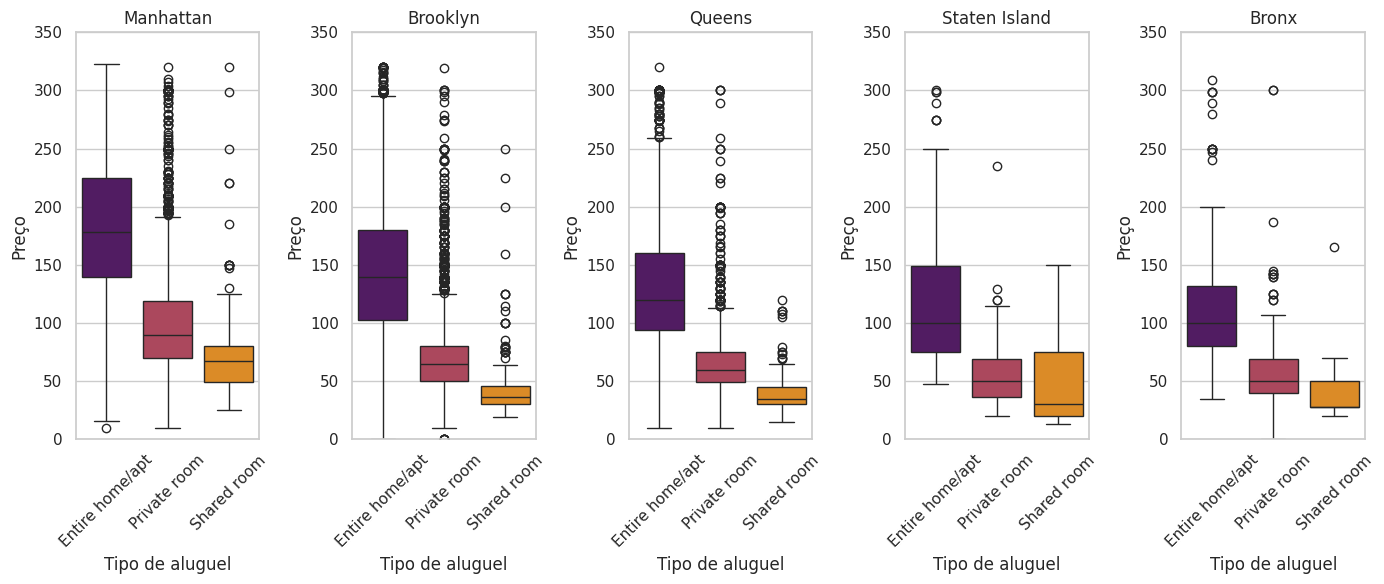

In [257]:
"""Verificar distribuição dos preços considerando região e tipo de aluguel"""

fig, axes = plt.subplots(1,5, figsize=(14, 6))
axes = axes.flatten()

regioes = df['bairro_group'].unique()
tipo_aluguel = df['room_type'].unique()

for i, regiao in enumerate(regioes):
    sns.boxplot(x='room_type', y='price',
                data=df[df['bairro_group'] == regiao],
                ax=axes[i],
                palette='inferno',
                order=tipo_aluguel)
    plt.title('Distribuição de preços por categoria', fontsize=16)
    axes[i].set_title(regiao)
    axes[i].set_xlabel('Tipo de aluguel')
    axes[i].set_ylabel('Preço')
    axes[i].set_ylim(0, 350)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Observa-se que, no geral, a mediana de preços entre tipos de aluguel se diferencia, sendo as casas/apartamentos inteiros mais caros que os quartos privados, que por sua vez são mais caros que os quartos compartilhados.

No entanto, observa-se também uma grande variabilidade dentro destes grupos, de tal forma que há quartos privados e quartos compartilhados que possuem preços semelhantes a casas/apartamentos inteiros, principalmente em Manhattan, Brooklyn e Queens.

In [258]:
def plotar_mapa(dados, df, titulo):
  plt.figure(figsize=(10, 6))
  sns.scatterplot(
      x=dados.longitude,
      y=dados.latitude,
      hue=df.bairro_group,
      size=df.price,
      sizes=(10, 300),
      palette='inferno'
  )
  plt.title(titulo)
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.legend()
  plt.show()

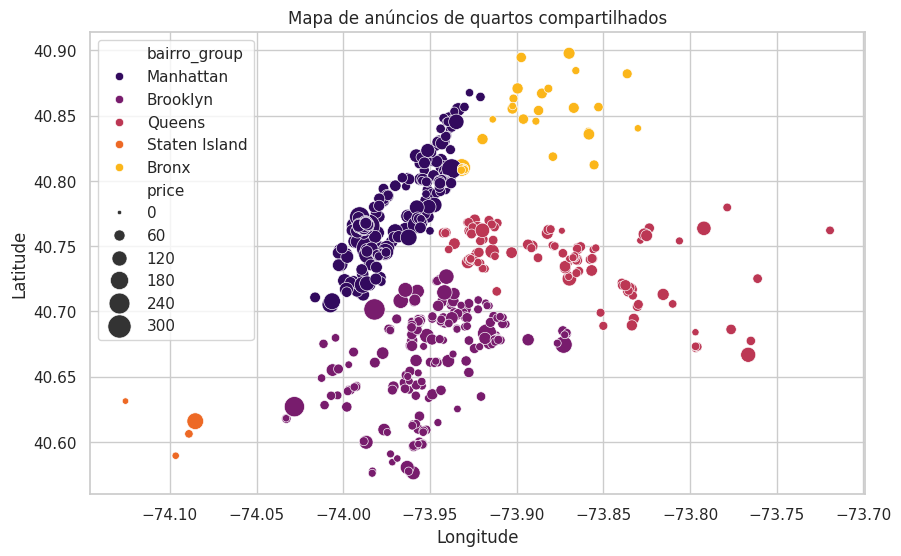

In [259]:
"""Plotar preços para shared rooms"""

dados = df[df['room_type'] == 'Shared room']

plotar_mapa(dados, df, "Mapa de anúncios de quartos compartilhados")

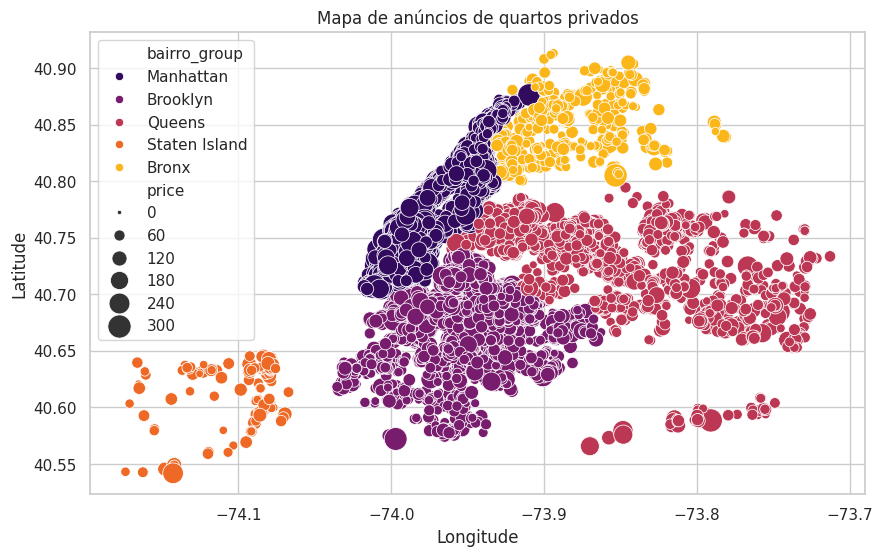

In [260]:
"""Preços para private rooms"""

dados = df[df['room_type'] == 'Private room']

plotar_mapa(dados, df, "Mapa de anúncios de quartos privados")

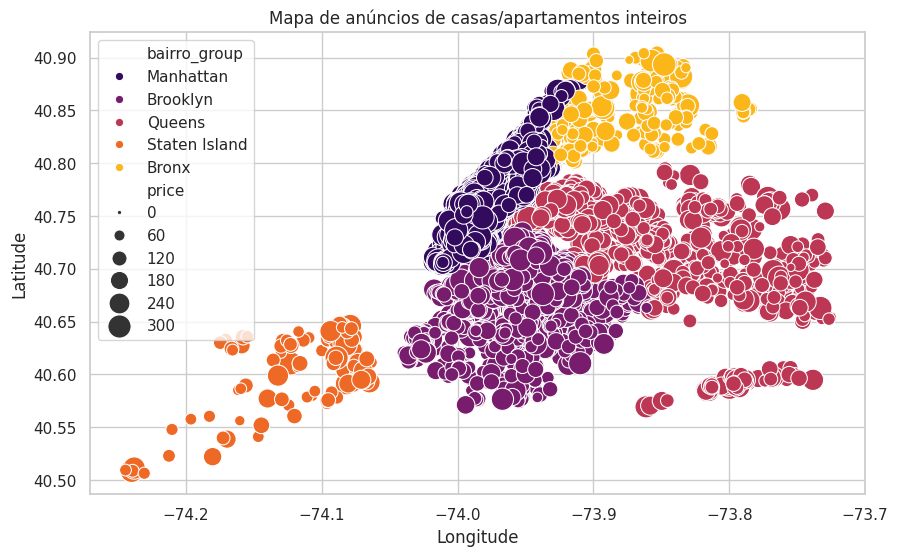

In [261]:
"""Preços para entire home/apt"""

dados = df[df['room_type'] == 'Entire home/apt']

plotar_mapa(dados, df, "Mapa de anúncios de casas/apartamentos inteiros")

## Associação entre variáveis preditoras qualitativas e variável resposta quantitativa

In [262]:
# Modelo ANOVA
modelo_1 = ols('price ~ bairro_group', data=df).fit()
anova_result = anova_lm(modelo_1)
print(anova_result)

                   df        sum_sq       mean_sq           F  PR(>F)
bairro_group      4.0  1.199107e+07  2.997768e+06  777.069867     0.0
Residual      26855.0  1.036008e+08  3.857784e+03         NaN     NaN


In [263]:
# Modelo ANOVA
modelo_2 = ols('price ~ bairro', data=df).fit()
anova_result = anova_lm(modelo_2)
print(anova_result)

               df        sum_sq        mean_sq          F  PR(>F)
bairro      216.0  2.778656e+07  128641.489606  39.034037     0.0
Residual  26643.0  8.780530e+07    3295.623463        NaN     NaN


In [264]:
# Modelo ANOVA
modelo_3 = ols('price ~ room_type', data=df).fit()
anova_result = anova_lm(modelo_3)
print(anova_result)

                df        sum_sq       mean_sq            F  PR(>F)
room_type      2.0  4.584974e+07  2.292487e+07  8828.140489     0.0
Residual   26857.0  6.974212e+07  2.596795e+03          NaN     NaN


## Associação entre variáveis qualitativas

In [265]:
"""Verificar o percentual de cada categoria de cada variável"""

df_cat = df[['bairro_group', 'bairro', 'room_type']]
print(df_cat['bairro_group'].value_counts(normalize=True)*100)
print(df_cat['bairro'].value_counts(normalize=True)*100)
print(df_cat['room_type'].value_counts(normalize=True)*100)

bairro_group
Brooklyn         44.378258
Manhattan        38.343261
Queens           13.373045
Bronx             2.844378
Staten Island     1.061057
Name: proportion, dtype: float64
bairro
Bedford-Stuyvesant    8.968727
Williamsburg          8.082651
Harlem                6.113179
Bushwick              5.443038
Hell's Kitchen        3.629933
                        ...   
Co-op City            0.003723
Rossville             0.003723
Willowbrook           0.003723
New Dorp Beach        0.003723
Richmondtown          0.003723
Name: proportion, Length: 217, dtype: float64
room_type
Private room       49.292628
Entire home/apt    48.291139
Shared room         2.416232
Name: proportion, dtype: float64


In [266]:
"""Teste Qui-Quadrado"""

tabela_mca_1 = chi2_contingency(pd.crosstab(df_cat['bairro_group'], df_cat['bairro']))
tabela_mca_2 = chi2_contingency(pd.crosstab(df_cat['bairro_group'], df_cat['room_type']))
tabela_mca_3 = chi2_contingency(pd.crosstab(df_cat['bairro'], df_cat['room_type']))

print(f"estatistica: {tabela_mca_1[0]}" + f"; p-valor da estatística: {round(tabela_mca_1[1], 4)}")
print(f"estatistica: {tabela_mca_2[0]}" + f"; p-valor da estatística: {round(tabela_mca_2[1], 4)}")
print(f"estatistica: {tabela_mca_3[0]}" + f"; p-valor da estatística: {round(tabela_mca_3[1], 4)}")

estatistica: 107440.0; p-valor da estatística: 0.0
estatistica: 380.01609200994926; p-valor da estatística: 0.0
estatistica: 3179.4071548564843; p-valor da estatística: 0.0


## Análise de correspondência múltipla

A análise de correspondência múltipla é uma técnica de machine learning não-supervisionada adequada para variáveis categóricas que possui como vantagem o output de um mapa 3D, chamado mapa perceptual, o qual é muito útil para visualizar a associação entre as categorias das variáveis qualitativas.

Vamos criar categorias de preços para visualizar a relação entre as categorias de `bairro_group` e `room_type` com `price` no mapa perceptual.

In [267]:
df['classe_preco'] = pd.qcut(df['price'], q=3, labels=['preco_baixo', 'preco_medio', 'preco_alto'])
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,classe_preco
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,preco_alto
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,preco_medio
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,preco_alto
6,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220,preco_medio
7,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0,preco_medio


In [268]:
df[['price', 'classe_preco']].groupby('classe_preco').describe()

price                                                          
               count        mean        std    min    25%    50%    75%    max
classe_preco                                                                  
preco_baixo   9009.0   55.391386  13.181805    0.0   45.0   55.0   65.0   75.0
preco_medio   9011.0  102.785706  16.665719   76.0   90.0  100.0  120.0  135.0
preco_alto    8840.0  196.608824  46.970092  136.0  154.0  187.0  225.0  323.0

Como a variável bairro possui mais de 200 categorias, ela não será utilizada nesta análise, pois o mapa perceptual ficaria extremamente poluído.

In [269]:
df_cat['classe_preco'] = df['classe_preco']
df_cat = df_cat.drop(columns=['bairro'])
df_cat.head()

,bairro_group,room_type,classe_preco
0,Manhattan,Entire home/apt,preco_alto
2,Brooklyn,Entire home/apt,preco_medio
4,Manhattan,Entire home/apt,preco_alto
6,Manhattan,Private room,preco_medio
7,Manhattan,Private room,preco_medio


In [270]:
mca = prince.MCA(n_components=3).fit(df_cat)

Os autovalores indicam o quanto cada componente foi capaz de separar bem as categorias das variáveis e explicar a variabilidade dos dados. Nesta análise, a variância total dos componentes utilizados foi de 48,56%. Caso a variável `bairro` fosse inclusa, o percentual da variância seria maior. No entanto, esse percentual já é suficiente para extrair insights sobre as variáveis utilizadas.

In [271]:
"""Análise dos autovalores"""
tabela_autovalores = mca.eigenvalues_summary
print(tabela_autovalores)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.594        22.26%                     22.26%
1              0.360        13.51%                     35.77%
2              0.335        12.55%                     48.32%


In [272]:
coord_padrao = mca.column_coordinates(df_cat)/np.sqrt(mca.eigenvalues_)

chart = coord_padrao.reset_index()
var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0])

nome_categ=[]
for col in df_cat:
    nome_categ.append(df_cat[col].sort_values(ascending=True).unique())
    categorias = pd.DataFrame(nome_categ).stack().reset_index()

chart_df_mca = pd.DataFrame({'categoria': chart['index'],
                             'obs_x': chart[0],
                             'obs_y': chart[1],
                             'obs_z': chart[2],
                             'variavel': var_chart,
                             'categoria_id': categorias[0]})

fig = px.scatter_3d(chart_df_mca,
                    x='obs_x',
                    y='obs_y',
                    z='obs_z',
                    color='variavel',
                    text=chart_df_mca.categoria_id)
fig.show()

Os aluguéis mais baixos (até 75 dólares) estão mais associados a quartos privados na região do Brooklyn.

Embora os quartos compartilhados tenham, em geral, os valores mais baixos conforme visualizado nos boxplots anteriormente, aqui eles aparecem mais distantes de todas classes, o que pode ser causado pelo menor número de anúncios de quartos compartilhados em comparação com os outros tipos de aluguéis (apenas 2% dos anúncios).

Como o mapa parceptual é baseado na frequência de cada categoria, isto pode ser diminuído sua associação com preço baixo. Esta é uma das vantagens do mapa perceptual sobre o boxplot, que é considerar um "peso" a ocorrência de cada variável para visualizar um padrão geral.

Por outro lado, os aluguéis de preços altos (de 136 a 323 dólares) podem ser encontrados frequentemente nos aluguéis de casas/apartamentos na região de Manhattan.

Já os aluguéis de preços médios (76 a 135 dólares) estão em um meio termo entre quartos privados no Brooklyn e casas/apartamentos em Manhattan.

Staten Island e Bronx não estão fortemente associados a algum tipo de aluguel ou classe de preço, ou seja, a variabilidade das categorias das variáveis é similar entre estas regiões.

Queens apresenta uma ocorrência moderada de quartos privados de preços baixos a médios.

# Analise dos melhores locais para investir

Vamos assumir que o melhor local para compra de um apartamento para alugar seja aquele em que o faturamento máximo anual seja a maior possível, valor que pode ser obtido ao multiplicar o valor da diária pelo número de dias disponíveis para locação ao ano.

Após isso, pode-se ordenar os dados pelo valor de faturamento máximo e identificar precisamente quais os imóveis que possuem o maior potencial de faturamento.

In [273]:
apartamentos = df[df['room_type'] == 'Entire home/apt']

In [274]:
apartamentos['rend_total_ano'] = apartamentos['price'] * apartamentos['disponibilidade_365']
apartamentos = apartamentos.sort_values(by='rend_total_ano', ascending=False)
apartamentos.head(10)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,classe_preco,rend_total_ano
38450,30264608,A slice of luxury In Cozy Chelsea loft!,226070943,Asia,Manhattan,Chelsea,40.74277,-74.00204,Entire home/apt,315,2,15,2019-07-05,2.09,1,365,preco_alto,114975
10117,7760808,West 57th Hilton Breakfast/Wine 30 sec from Pa...,4403646,Paul,Manhattan,Midtown,40.76352,-73.97770,Entire home/apt,319,4,9,2018-09-09,0.24,1,358,preco_alto,114202
18212,14274809,Amazing Location 2 BR 2 Full Bath East Village,7118541,Jared,Manhattan,East Village,40.72714,-73.98668,Entire home/apt,316,3,74,2019-06-08,2.19,1,348,preco_alto,109968
778,279093,Huge Apartment! Amazing View!,1455825,Erica,Manhattan,Harlem,40.82977,-73.94071,Entire home/apt,300,3,2,2018-04-10,0.06,1,365,preco_alto,109500
2712,1462341,Great Apt/Roof in Hells Kitchen,7837136,Jorion,Manhattan,Hell's Kitchen,40.76582,-73.99468,Entire home/apt,300,2,23,2018-09-23,0.32,1,365,preco_alto,109500
46320,35195915,Chelsea HIGHLINE Prime Location,244131674,Alexis,Manhattan,Chelsea,40.74900,-74.00244,Entire home/apt,300,2,3,2019-07-07,3.00,1,365,preco_alto,109500
32163,25140344,Rare artist loft with private terrace,5758101,Laure-Anne,Brooklyn,Williamsburg,40.70376,-73.93519,Entire home/apt,300,2,13,2019-06-30,1.01,1,365,preco_alto,109500
2339,1137093,Triplex Penthouse in New York,5446918,Paresh,Brooklyn,Williamsburg,40.71756,-73.94839,Entire home/apt,300,5,34,2019-06-15,0.46,1,365,preco_alto,109500
46786,35442636,The perfect summer NYC gem,266699294,Tiffany,Manhattan,East Harlem,40.79136,-73.93979,Entire home/apt,300,2,1,2019-06-24,1.00,1,365,preco_alto,109500
19216,15301499,~**GORGEOUS DOWNTOWN LOFTS**~ MULTIPLE SPACES,76192815,Sam,Manhattan,Chinatown,40.71745,-73.99409,Entire home/apt,300,1,23,2019-03-27,0.69,5,364,preco_alto,109200


Como já foi observado pelos gráficos feitos anteriormente, a região de Manhattan apresenta a maior mediana de aluguel de casas/apartamentos inteiros, se comparada às outras regiões.

É possível refinar a análise para visualizar os bairros desta região e analisar a mediana do rendimento que o aluguel dos imóveis pode proporcionar ao investidor. Foi utilizada a mediana, pois a média é sensível a não-normalidade dos dados e também ao número de dados (por isso, é apresentado também o número de anúncios de imóveis em cada bairro).

In [275]:
manhattan = apartamentos[apartamentos['bairro_group'] == 'Manhattan']

In [276]:
rend_medio_total_ano_bairro = pd.DataFrame(manhattan.groupby('bairro')['rend_total_ano'].median().sort_values(ascending=False).head(10))
rend_medio_total_ano_bairro['numero_imoveis'] = manhattan['bairro'].value_counts()
rend_medio_total_ano_bairro

,rend_total_ano,numero_imoveis
bairro,,
Financial District,64961.0,213
Marble Hill,23623.5,2
Little Italy,20100.0,30
Midtown,15680.0,306
NoHo,15045.0,25
Theater District,14525.0,17
Murray Hill,14400.0,87
Two Bridges,10300.0,18
Hell's Kitchen,9900.0,465


Aqui observa-se que o bairro de Manhattan com maior potencial de faturamento com aluguel de casas é o Financial District.

Abaixo é possível ver diretamente quais são os 5 imóveis em Financial District e o valor máximo que eles podem gerar anualmente.

In [277]:
financial_district = manhattan[manhattan['bairro'] == 'Financial District']
financial_district = financial_district.sort_values(by='rend_total_ano', ascending=False)
financial_district.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,classe_preco,rend_total_ano
18221,14280163,Large modern chic 1-BR apt near World Trade Ce...,60557711,Sameer,Manhattan,Financial District,40.70851,-74.00563,Entire home/apt,300,6,3,2018-12-30,0.10,1,358,preco_alto,107400
15448,12385794,"CLEAN,SPACIOUS,CONVENIENT,FiDi/NYC Apartment",7511223,Shan,Manhattan,Financial District,40.70799,-74.00977,Entire home/apt,300,3,100,2019-06-22,2.66,1,335,preco_alto,100500
41131,31988074,"LYRIC - 1 Bedroom Suite, 2 Bath, Kitchen",197053492,Lyric At 70 Pine,Manhattan,Financial District,40.70760,-74.00740,Entire home/apt,309,1,1,2019-05-19,0.59,8,314,preco_alto,97026
41384,32225195,Sonder | Stock Exchange | Beautiful 1BR + Kitchen,219517861,Sonder (NYC),Manhattan,Financial District,40.70732,-74.01029,Entire home/apt,240,2,8,2019-06-20,1.98,327,357,preco_alto,85680
46928,35492191,Budget-Friendly 1 Bedroom 1 Bath near Wall St,71577601,Gensing,Manhattan,Financial District,40.70595,-74.00974,Entire home/apt,250,2,2,2019-06-21,2.00,1,335,preco_alto,83750


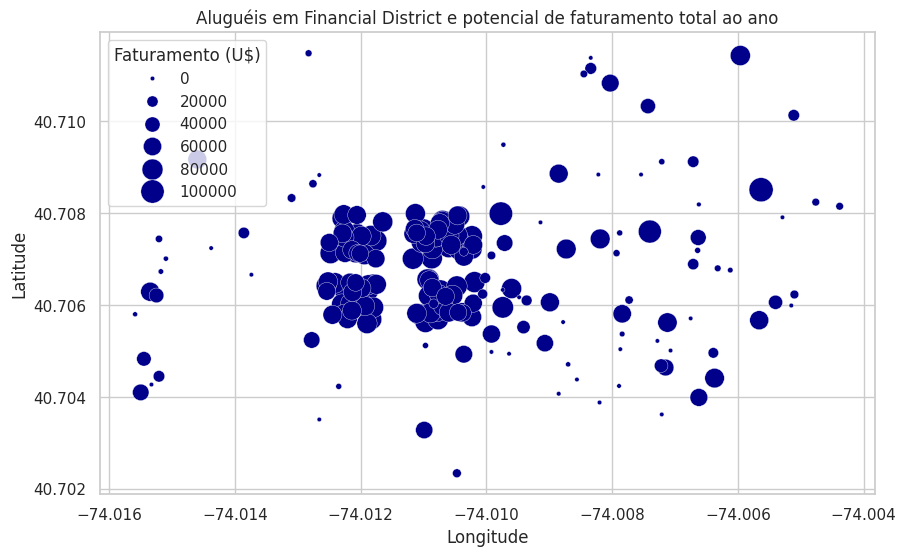

In [278]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
      x=financial_district.longitude,
      y=financial_district.latitude,
      size=financial_district.rend_total_ano,
      sizes=(10, 300),
      color="darkblue"
  )
plt.title("Aluguéis em Financial District e potencial de faturamento total ao ano")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Faturamento (U$)")
plt.show()

As regiões com maior adensamento indicam que há grande quantidade de anúncios de aluguel. Apesar da grande concorrência, observa-se que os valores de rendimento anual são intermediários a altos. Sendo assim, é importante avaliar não apenas o potencial de faturamento, mas também o contexto local e como isso pode afetar a demanda por locação.

# Análise do título dos anúncios de locais de mais alto valor

Para observar um padrão no texto dos anúncios de lugares com preços mais altos, pode ser realizada uma contagem da frequência de palavras (tokens).

In [279]:
preco_alto = df[df['classe_preco'] == 'preco_alto']
preco_alto = preco_alto[['classe_preco', 'nome']]
preco_alto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8840 entries, 0 to 48798
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   classe_preco  8840 non-null   category
 1   nome          8840 non-null   object  
dtypes: category(1), object(1)
memory usage: 146.9+ KB


In [280]:
def tokenizar(texto):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(texto.lower())
    tokens_sem_stopwords = [token for token in tokens if token not in stop_words and token.isalpha()]
    return tokens_sem_stopwords

preco_alto['tokens'] = preco_alto['nome'].apply(tokenizar)
preco_alto.head()

,classe_preco,nome,tokens
0,preco_alto,Skylit Midtown Castle,"[skylit, midtown, castle]"
4,preco_alto,Large Cozy 1 BR Apartment In Midtown East,"[large, cozy, br, apartment, midtown, east]"
8,preco_alto,Cute & Cozy Lower East Side 1 bdrm,"[cute, cozy, lower, east, side, bdrm]"
14,preco_alto,Only 2 stops to Manhattan studio,"[stops, manhattan, studio]"
15,preco_alto,Perfect for Your Parents + Garden,"[perfect, parents, garden]"


In [281]:
"""Contar os tokens e selecionar os 10 tokens mais frequentes"""

todos_tokens = sum(preco_alto['tokens'].tolist(), [])
frequencia = Counter(todos_tokens)
top_10_tokens = frequencia.most_common(10)
print(top_10_tokens)

tokens, counts = zip(*top_10_tokens)

[('apartment', 1588), ('bedroom', 1273), ('apt', 1090), ('studio', 889), ('spacious', 806), ('village', 719), ('east', 716), ('brooklyn', 701), ('private', 690), ('cozy', 684)]


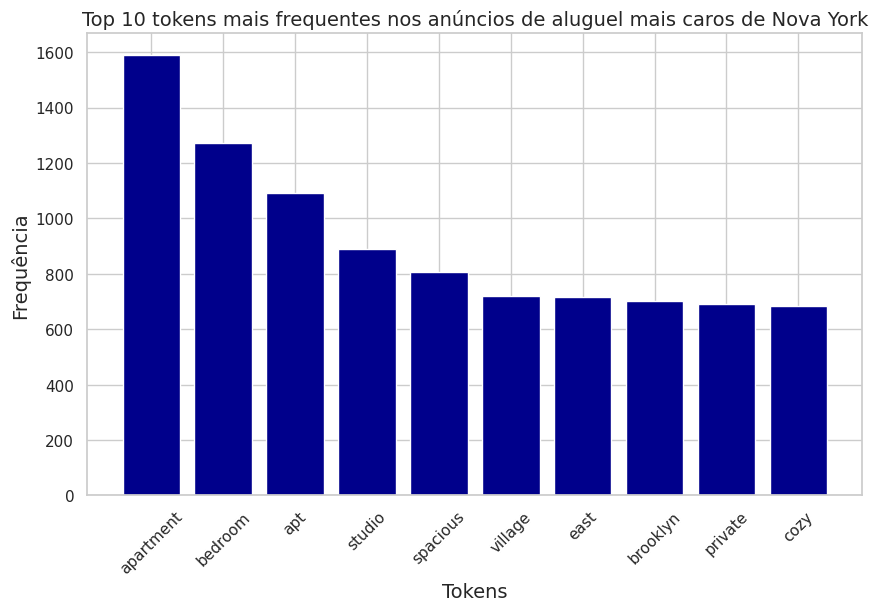

In [282]:
plt.figure(figsize=(10, 6))
plt.bar(tokens, counts, color='darkblue')
plt.title('Top 10 tokens mais frequentes nos anúncios de aluguel mais caros de Nova York', fontsize=14)
plt.xlabel('Tokens', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=45)
plt.show()

As palavras mais frequentes fazem referência ao tipo de local (apartment, apt, studio, village, bedroom), e também a qualidades do local (spacious, private, cozy). As palavras east e brooklyn dão ideia de localização, tendo apenas função descritiva.

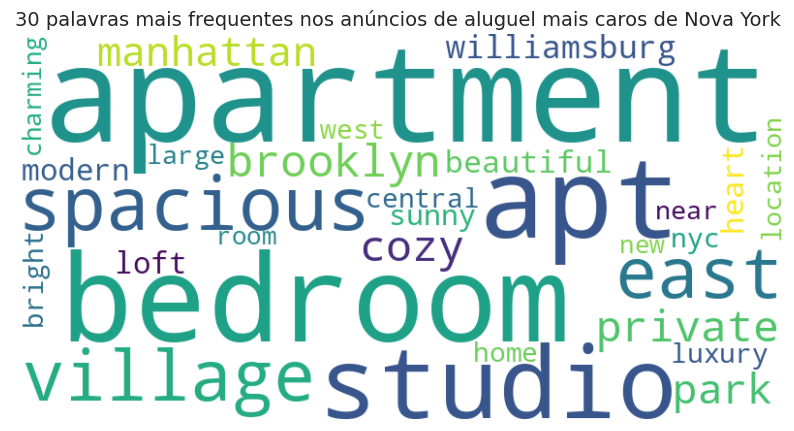

In [283]:
"""Visualizar os 30 tokens mais frequentes"""

top_50_tokens = dict(frequencia.most_common(30))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_50_tokens)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('30 palavras mais frequentes nos anúncios de aluguel mais caros de Nova York', fontsize=14)
plt.show()

Outras palavras também frequentes nos títulos dos anúncios também associadas a qualidade foram bright, luxury, sunny, large, modern, beautiful, charming e new, por exemplo.

Outras palavras associadas a localização foram manhattan, heart, location, west, central, near, williamsburg, nyc, por exemplo.


# Regressão linear múltipla

In [284]:
df_reg = df.drop(columns = ['classe_preco', 'id', 'nome', 'host_id', 'host_name', 'bairro', 'ultima_review'])
df_reg.head()

,bairro_group,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129
6,Manhattan,40.76489,-73.98493,Private room,79,2,430,3.47,1,220
7,Manhattan,40.80178,-73.96723,Private room,79,2,118,0.99,1,0


In [285]:
"""Obter dummies das variáveis qualitativas"""

df_dummies = pd.get_dummies(df_reg, columns=['bairro_group', 'room_type'],
                                      dtype=int,
                                      drop_first=True)

"""Tratamento dos nomes das variáveis para evitar erros no modelo"""
df_dummies.columns = df_dummies.columns.str.replace(' ', '_')
df_dummies.columns = df_dummies.columns.str.lower()

df_dummies.head()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_group_brooklyn,bairro_group_manhattan,bairro_group_queens,bairro_group_staten_island,room_type_private_room,room_type_shared_room
0,40.75362,-73.98377,225,1,45,0.38,2,355,0,1,0,0,0,0
2,40.68514,-73.95976,89,1,270,4.64,1,194,1,0,0,0,0,0
4,40.74767,-73.97500,200,3,74,0.59,1,129,0,1,0,0,0,0
6,40.76489,-73.98493,79,2,430,3.47,1,220,0,1,0,0,1,0
7,40.80178,-73.96723,79,2,118,0.99,1,0,0,1,0,0,1,0


In [286]:
"Definir a fórmula a ser inserida no modelo"

features = df_dummies.drop(columns=['price'])
lista_colunas = list(features.columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "price ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)


Fórmula utilizada:  price ~ latitude + longitude + minimo_noites + numero_de_reviews + reviews_por_mes + calculado_host_listings_count + disponibilidade_365 + bairro_group_brooklyn + bairro_group_manhattan + bairro_group_queens + bairro_group_staten_island + room_type_private_room + room_type_shared_room


In [287]:
modelo_dummies_stepwise = stepwise(sm.OLS.from_formula(formula_dummies_modelo,
                                               df_dummies).fit(),
                                   pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 price ~ Q('latitude') + Q('longitude') + Q('minimo_noites') + Q('numero_de_reviews') + Q('reviews_por_mes') + Q('calculado_host_listings_count') + Q('disponibilidade_365') + Q('bairro_group_brooklyn') + Q('bairro_group_manhattan') + Q('bairro_group_queens') + Q('bairro_group_staten_island') + Q('room_type_private_room') + Q('room_type_shared_room')

 Discarding atribute "Q('bairro_group_brooklyn')" with p-value equal to 0.11752126530658236 

Estimating model...: 
 price ~ Q('latitude') + Q('longitude') + Q('minimo_noites') + Q('numero_de_reviews') + Q('reviews_por_mes') + Q('calculado_host_listings_count') + Q('disponibilidade_365') + Q('bairro_group_manhattan') + Q('bairro_group_queens') + Q('bairro_group_staten_island') + Q('room_type_private_room') + Q('room_type_shared_room')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('bairro_group_brooklyn')", 'p-value': 0.11752126530658

In [288]:
"""Teste de Shapiro-Francia para avaliação da normalidade dos resíduos"""

teste_sf = shapiro_francia(modelo_dummies_stepwise.resid)
teste_sf = teste_sf.items()
method, statistics_W, statistics_z, p = teste_sf
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9486397518368814
statistics z  :  18.462684336484728
p-value  :  2.061652808148786e-76
Statistics W=0.94864, p-value=0.000000
Rejeita-se H0 - Distribuição não aderente à normalidade


Uma das causas da não-aderência dos resíduos à normalidade é o fato de a variável resposta não ter uma distribuição normal, o que pode ser visualizado abaixo.

<Axes: >

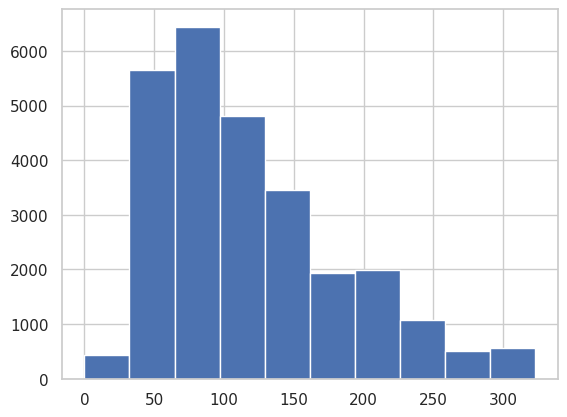

In [289]:
df_reg['price'].hist()

A transformação de Box-Cox da variável resposta pode melhorar o ajuste dos resíduos do modelo.

In [290]:
df_dummies['price'] = df_dummies['price'] + 0.001

"""'yast' é uma variável que traz os valores transformados (Y*)"""
"""'lmbda' é o lambda de Box-Cox"""
yast, lmbda = boxcox(df_dummies['price'])

df_dummies['price_bc'] = yast
print("Lambda: ",lmbda)

Lambda:  0.22246548169533664


In [291]:
features = df_dummies.drop(columns=['price', 'price_bc'])
lista_colunas = list(features.columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "price_bc ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  price_bc ~ latitude + longitude + minimo_noites + numero_de_reviews + reviews_por_mes + calculado_host_listings_count + disponibilidade_365 + bairro_group_brooklyn + bairro_group_manhattan + bairro_group_queens + bairro_group_staten_island + room_type_private_room + room_type_shared_room


In [292]:
modelo_dummies_stepwise_bc = stepwise(sm.OLS.from_formula(formula_dummies_modelo,
                                               df_dummies).fit(),
                                      pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 price_bc ~ Q('latitude') + Q('longitude') + Q('minimo_noites') + Q('numero_de_reviews') + Q('reviews_por_mes') + Q('calculado_host_listings_count') + Q('disponibilidade_365') + Q('bairro_group_brooklyn') + Q('bairro_group_manhattan') + Q('bairro_group_queens') + Q('bairro_group_staten_island') + Q('room_type_private_room') + Q('room_type_shared_room')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 


 Model after stepwise process...: 
 price_bc ~ Q('latitude') + Q('longitude') + Q('minimo_noites') + Q('numero_de_reviews') + Q('reviews_por_mes') + Q('calculado_host_listings_count') + Q('disponibilidade_365') + Q('bairro_group_brooklyn') + Q('bairro_group_manhattan') + Q('bairro_group_queens') + Q('bairro_group_staten_island') + Q('room_type_private_room') + Q('room_type_shared_room') 

                            OLS Regression Results                            
Dep. Variable:               price_

In [293]:
teste_sf = shapiro_francia(modelo_dummies_stepwise_bc.resid)
teste_sf = teste_sf.items()
method, statistics_W, statistics_z, p = teste_sf
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9785833545116004
statistics z  :  16.012162109449214
p-value  :  5.25467200397426e-58
Statistics W=0.97858, p-value=0.000000
Rejeita-se H0 - Distribuição não aderente à normalidade


Mesmo após a transformação de Box-Cox, o modelo ainda não apresentou distribuição dos resíduos aderente à normalidade.

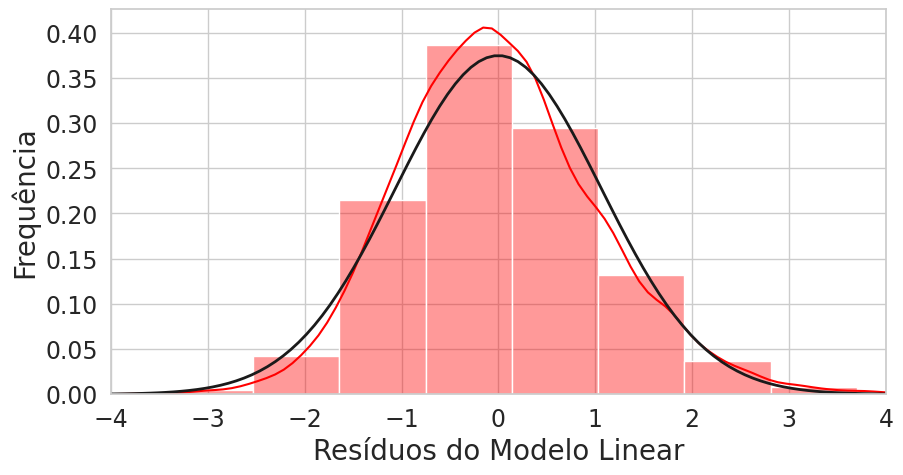

In [294]:
"""Calcula os valores de ajuste da distribuição normal"""
(mu, sigma) = norm.fit(modelo_dummies_stepwise_bc.resid)

"""Gráfico propriamente dito"""
plt.figure(figsize=(10,5))
sns.histplot(modelo_dummies_stepwise_bc.resid, bins=20, kde=True, stat="density",
             color='red', alpha=0.4)
plt.xlim(-4, 4)
x = np.linspace(-4, 4, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Linear', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()


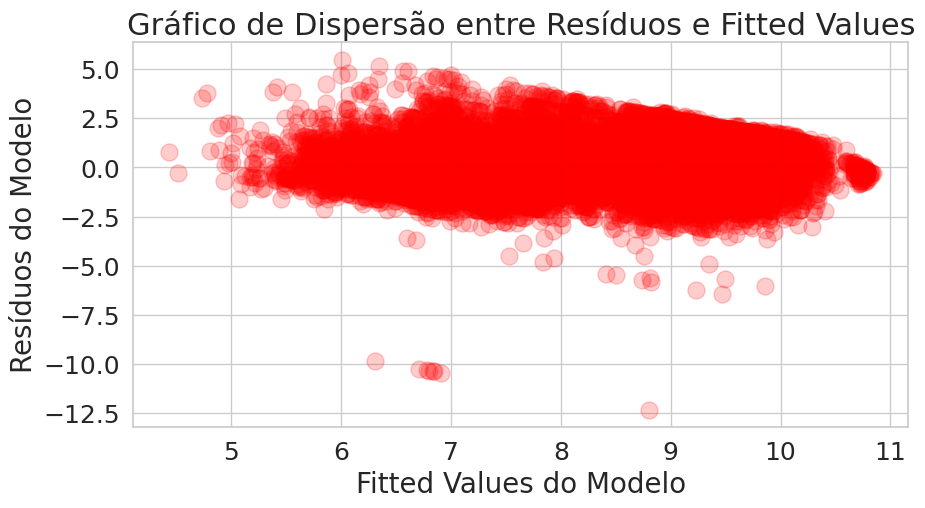

In [295]:
df_fitted = pd.DataFrame({'fitted': modelo_dummies_stepwise_bc.fittedvalues})
df_fitted['residuos'] = modelo_dummies_stepwise_bc.resid

plt.figure(figsize=(10,5))
sns.regplot(x='fitted', y='residuos', data=df_fitted,
            marker='o', fit_reg=False,
            scatter_kws={"color":'red', 'alpha':0.2, 's':150})
plt.title('Gráfico de Dispersão entre Resíduos e Fitted Values', fontsize=22)
plt.xlabel('Fitted Values do Modelo', fontsize=20)
plt.ylabel('Resíduos do Modelo', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

O gráfico de distribuição dos resíduos mostra que há uma maior proporção de valores valores preditos que foram maiores que os observados. Isso levou os resíduos a terem uma calda longa a esquerda, e por isso eles não apresentaram distribuição normal. Portanto, o modelo não atende a um dos requisitos necessários para que a regressão linear seja utilizada como método preditivo confiável.


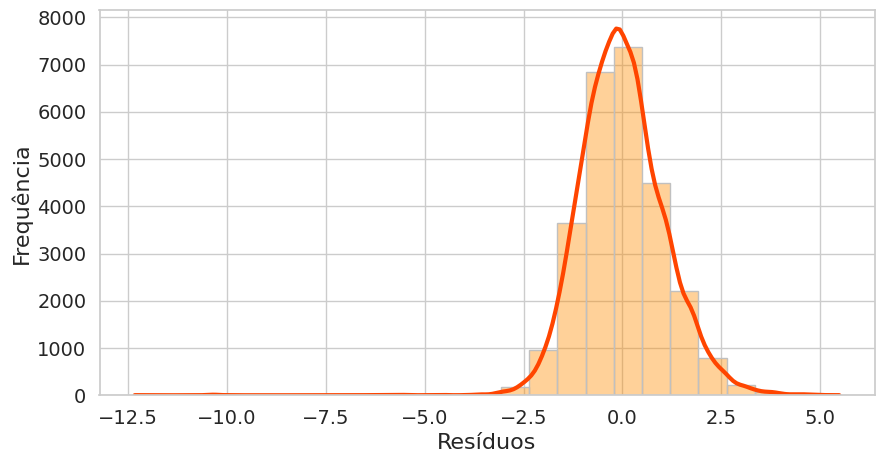

In [296]:
plt.figure(figsize=(10,5))
hist1 = sns.histplot(data=modelo_dummies_stepwise_bc.resid, kde=True, bins=25,
                     color = 'darkorange', alpha=0.4, edgecolor='silver',
                     line_kws={'linewidth': 3})
hist1.get_lines()[0].set_color('orangered')
plt.xlabel('Resíduos', fontsize=16)
plt.ylabel('Frequência', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Outra causa de não-normalidade dos resíduos pode ser a presença de multicolinearidade, que é a correlação entre variáveis preditoras, que pode ser detectada com o teste VIF (Variance Inflation Factor). Quanto maior o VIF, maior é a multicolinearidade.

In [297]:
"""Calculando os valores de VIF"""

X1 = sm.add_constant(df_dummies.drop(columns=['price', 'price_bc']))
VIF = pd.DataFrame()
VIF["Variável"] = X1.columns[1:]
VIF["VIF"] = [variance_inflation_factor(X1.values, i+1)
              for i in range(X1.shape[1]-1)]

"""Calculando as Tolerâncias"""
VIF["Tolerância"] = 1 / VIF["VIF"]
VIF

,Variável,VIF,Tolerância
0,latitude,2.882106,0.346969
1,longitude,2.601338,0.384418
2,minimo_noites,1.134488,0.881455
3,numero_de_reviews,1.461860,0.684060
4,reviews_por_mes,1.532054,0.652719
5,calculado_host_listings_count,1.054399,0.948407
6,disponibilidade_365,1.136452,0.879932
7,bairro_group_brooklyn,15.295814,0.065377
8,bairro_group_manhattan,11.553097,0.086557
9,bairro_group_queens,6.437158,0.155348


A regressão linear foi testada novamente sem utilizar as variáveis com alto VIF ('price', 'price_bc', 'latitude', 'bairro_group_brooklyn', 'bairro_group_manhattan', 'bairro_group_queens', 'bairro_group_staten_island'). No entanto, como os resíduos continuaram a apresentar o mesmo padrão, esta regressão não será apresentada aqui.

Uma hipótese é de que exista heterocedasticidade, ou seja, a variância de uma ou mais variáveis preditoras aumenta em conjunto com a variável resposta.

In [298]:
"""Criação da função 'breusch_pagan_test'"""

def breusch_pagan_test(modelo):

    df = pd.DataFrame({'yhat':modelo.fittedvalues,
                       'resid':modelo.resid})

    df['up'] = (np.square(df.resid))/np.sum(((np.square(df.resid))/df.shape[0]))

    modelo_aux = sm.OLS.from_formula('up ~ yhat', df).fit()

    anova_table = sm.stats.anova_lm(modelo_aux, typ=2)

    anova_table['sum_sq'] = anova_table['sum_sq']/2

    chisq = anova_table['sum_sq'].iloc[0]

    p_value = stats.chi2.pdf(chisq, 1)*2

    print(f"chisq: {chisq}")

    print(f"p-value: {p_value}")

    return chisq, p_value

In [299]:
"""Interpretação do teste de heterocedasticidade"""

teste_bp = breusch_pagan_test(modelo_dummies_stepwise_bc)
chisq, p = teste_bp
alpha = 0.05
if p > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade')
else:
	print('Rejeita-se H0 - Existência de Heterocedasticidade')

chisq: 10.021343319742124
p-value: 0.0016802350447320306
Rejeita-se H0 - Existência de Heterocedasticidade


Como a regressão linear não respondeu bem aos dados, mesmo não havendo heterocedasticidade e após remover a multicolinearidade, será necessário testar outros modelos que não precisam assumir a normalidade dos resíduos.

# Árvore de Regressão, Random Forest e XGBoost

In [300]:
"""Separar as variáveis independentes (X) e dependente (y)"""
X = df_dummies.drop(columns=['price_bc', 'price'])
y = df_dummies['price_bc']

"""Dividir os dados em treinamento e teste"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [301]:
def testar_modelo(model, X_train, y_train, X_test, y_test):

  """Treinar o modelo"""
  model.fit(X_train, y_train)

  """Fazer previsões"""
  y_pred = model.predict(X_test)

  """Avaliar o modelo"""
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

  print("Mean Squared Error (MSE):", mse)
  print("Mean Absolute Percentage Error (MAPE):", mape)
  print("Coeficiente de determinação (R²):", r2)

  """Importância das variáveis"""
  importances = model.feature_importances_
  feature_importances = pd.DataFrame({'Variável': X.columns, 'Importância': importances}).sort_values(by='Importância', ascending=False)
  print(feature_importances)

In [302]:
"""Criar o modelo de árvore de regressão"""

modelo_decis_tree = DecisionTreeRegressor(random_state=42)

testar_modelo(modelo_decis_tree, X_train, y_train, X_test, y_test)

Mean Squared Error (MSE): 1.9677041837501588
Mean Absolute Percentage Error (MAPE): 13.187373388458546
Coeficiente de determinação (R²): 0.2343456734239161
                         Variável  Importância
11         room_type_private_room     0.356467
0                        latitude     0.147724
1                       longitude     0.127727
12          room_type_shared_room     0.087599
6             disponibilidade_365     0.072058
4                 reviews_por_mes     0.063502
3               numero_de_reviews     0.051133
8          bairro_group_manhattan     0.043254
2                   minimo_noites     0.025464
5   calculado_host_listings_count     0.021889
9             bairro_group_queens     0.002138
7           bairro_group_brooklyn     0.000792
10     bairro_group_staten_island     0.000255


In [303]:
"""Criar o modelo Random Forest"""

modelo_rand_for = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
)

testar_modelo(modelo_rand_for, X_train, y_train, X_test, y_test)

Mean Squared Error (MSE): 1.0715696982100529
Mean Absolute Percentage Error (MAPE): 10.035016371671809
Coeficiente de determinação (R²): 0.5830409964882561
                         Variável  Importância
11         room_type_private_room     0.597570
12          room_type_shared_room     0.147514
8          bairro_group_manhattan     0.080522
0                        latitude     0.074739
1                       longitude     0.070334
6             disponibilidade_365     0.022880
5   calculado_host_listings_count     0.003425
4                 reviews_por_mes     0.002484
2                   minimo_noites     0.000236
3               numero_de_reviews     0.000234
10     bairro_group_staten_island     0.000048
7           bairro_group_brooklyn     0.000014
9             bairro_group_queens     0.000000


In [304]:
"""Criar o modelo XGBoost"""

modelo_xgboost = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)

testar_modelo(modelo_xgboost, X_train, y_train, X_test, y_test)

Mean Squared Error (MSE): 0.9628275842327456
Mean Absolute Percentage Error (MAPE): 9.395789446902299
Coeficiente de determinação (R²): 0.6253536930487096
                         Variável  Importância
11         room_type_private_room     0.582435
12          room_type_shared_room     0.209517
8          bairro_group_manhattan     0.155887
1                       longitude     0.013717
0                        latitude     0.012848
6             disponibilidade_365     0.007695
2                   minimo_noites     0.003988
5   calculado_host_listings_count     0.003834
3               numero_de_reviews     0.003200
4                 reviews_por_mes     0.002917
7           bairro_group_brooklyn     0.002444
9             bairro_group_queens     0.001519
10     bairro_group_staten_island     0.000000


Comparando o MAPE entre os modelos, identificou-se que o melhor modelo foi o XGBoost.

O R² deste modelo indicou um ajuste moderado aos dados de treinamento. Caso outras variáveis fossem adicionadas, como características dos imóveis e proximidade a pontos turísticos, o percentual de variância explicada pelo modelo poderia ser ainda maior.

In [305]:
"""Salvar modelo em formato .pkl"""

with open("modelo_xgboost.pkl", "wb") as file:
    pickle.dump(modelo_xgboost, file)

# Previsão com o melhor modelo

Como o modelo XGBoost foi o que se saiu melhor, ele será utilizado para prever o preço de aluguel de um apartamento com as seguintes características:

In [306]:
"""Carregar modelo em formato .pkl"""

with open("modelo_xgboost.pkl", "rb") as file:
    modelo = pickle.load(file)

In [307]:
dados = pd.DataFrame({'id': [2595],
        'nome': ['Skylit Midtown Castle'],
        'host_id': [2845],
        'host_name': ['Jennifer'],
        'bairro_group': ['Manhattan'],
        'bairro': ['Midtown'],
        'latitude': [40.75362],
        'longitude': [-73.98377],
        'room_type': ['Entire home/apt'],
        'minimo_noites': [1],
        'numero_de_reviews': [45],
        'ultima_review': ['2019-05-21'],
        'reviews_por_mes': [0.38],
        'calculado_host_listings_count': [2],
        'disponibilidade_365': [355]
        })

dados.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2019-05-21,0.38,2,355


In [308]:
"""Retirar variáveis que não estão no modelo"""

dados = dados.drop(columns=['id', 'bairro_group', 'room_type', 'nome', 'host_id', 'host_name', 'ultima_review', 'bairro'], axis=1)

"""Adicionar dummies manualmente (já que temos apenas uma categoria, a função get_dummies não funciona)"""

dummies = pd.DataFrame({'bairro_group_brooklyn': [0],
                        'bairro_group_manhattan': [1],
                        'bairro_group_queens': [0],
                        'bairro_group_staten_island': [0],
                        'room_type_private_room': [0],
                        'room_type_shared_room': [0]})

dados = pd.concat([dados, dummies], axis=1)

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   latitude                       1 non-null      float64
 1   longitude                      1 non-null      float64
 2   minimo_noites                  1 non-null      int64  
 3   numero_de_reviews              1 non-null      int64  
 4   reviews_por_mes                1 non-null      float64
 5   calculado_host_listings_count  1 non-null      int64  
 6   disponibilidade_365            1 non-null      int64  
 7   bairro_group_brooklyn          1 non-null      int64  
 8   bairro_group_manhattan         1 non-null      int64  
 9   bairro_group_queens            1 non-null      int64  
 10  bairro_group_staten_island     1 non-null      int64  
 11  room_type_private_room         1 non-null      int64  
 12  room_type_shared_room          1 non-null      int64  

In [309]:
previsao = modelo.predict(pd.DataFrame(dados, index=[0]))

"""Fazer o cálculo inverso da transformação de Box-Cox para obter o valor previsto original"""

previsao = (previsao * lmbda + 1) ** (1 / lmbda)

print(f"Preço previsto: {previsao}")

Preço previsto: [210.25581]


O preço estimado do aluguel diário de uma casa/apartamento em Midtown - Manhattan, com dispobilidade ao ano de 355 dias, é de U$210,25.

Pelos boxplots observados anteriormente, podemos notar que 25% das casas/apartamentos em Manhattan possuem preços entre 180 a 220 dólares.

Portanto, o valor previsto está dentro da faixa de valores observados.

